In [1]:
%pylab inline

from scipy.ndimage.filters import gaussian_filter
from PyTools import integrated_flux, binner, nbins
import os, pres_style

def mag2flux(mag, wlength):
    return 10**(-0.4 * (mag - 22.5)) * 3.631e-6 * 1e-23 * (299792458.0E10/wlength**2)
def flux2mag(flux, wlength):
    return -2.5*log10(flux / 3.631e-6 / 1e-23 / (299792458.0E10/wlength**2)) + 22.5

Populating the interactive namespace from numpy and matplotlib


In [2]:
def CCM(wlength, Av, Rv=3.1):
    a, b = [], []
    for x in 1.e4 / wlength:
        #Infrared:  Eq. 2
        if x >= 0.3 and x < 1.1:
            a.append(0.574*x**1.61)
            b.append(-0.527*x**1.61)
        #Optical/NIR:  Eq. 3
        elif x >= 1.1 and x < 3.3:
            y=x-1.82
            a.append(1.+0.17699*y-0.50447*y**2-0.02427*y**3+0.72085*y**4+0.01979*y**5-0.77530*y**6+0.32999*y**7)
            b.append(1.41338*y+2.28305*y**2+1.07233*y**3-5.38434*y**4-0.62251*y**5+5.30260*y**6-2.09002*y**7)
        #Ultraviolet:  Eq.4
        elif x >= 3.3  and  x < 8.:
            fa=0.
            fb=0.
            if x>=5.9:
                fa=-0.04473*(x-5.9)**2-0.009779*(x-5.9)**3
                fb=0.2130*(x-5.9)**2+0.1207*(x-5.9)**3

            a.append(1.752-0.316*x-0.104/((x-4.67)**2+0.341)+fa)
            b.append(-3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb)
        #Far-UV:  Eq. 5
        elif x>=8 and x<=10.:
            a.append(-1.073-0.628*(x-8.)+0.137*(x-8.)**2-0.070*(x-8)**3)
            b.append(13.670+4.257*(x-8)-0.420*(x-8)**2+0.374*(x-8)**3)
        else:
            a.append(0.0)
            b.append(0.0)

    a = array(a)
    b = array(b)
    return 10 ** (-0.4 * Av * (a + b) / Rv)

In [3]:
odir = "../inputs/real_deal7/"

u_obf, g_obf, r_obf, i_obf, z_obf, rs_sam = loadtxt("data/Samples/ugriz_catalog_of.txt", usecols=range(1, 6)+[11], unpack=True)
u_ref, g_ref, r_ref, i_ref, z_ref = loadtxt("data/Samples/ugriz_catalog_rf.txt", usecols=range(1, 6), unpack=True)
pu_set, pg_set, pr_set, pi_set, pz_set, u_set, g_set, r_set, i_set, z_set = loadtxt("../inputs/SSAG_catalog.txt", usecols=range(27,27+5)+range(40,40+5), unpack=True)
Av = loadtxt("../inputs/real_deal7/outs/spec/dynbas_output.log", usecols=(7,))

knames = loadtxt("data/Samples/ugriz_catalog_rf.txt", dtype=str, usecols=(0,))
mnames = loadtxt("data/RealDeal/rd7_master.txt", dtype=str)
snames = loadtxt("data/RealDeal/rd7_sample.txt", dtype=str)
dnames = loadtxt("../inputs/real_deal7/outs/spec/dynbas_output.log", dtype=str, usecols=(0,))
dnames = array([name.replace("dynbasfit_processed_SPEC_", "").replace(".log", ".fit") for name in dnames], dtype=str)

weff = array([3.5618E+03, 4.7189E+03, 6.1852E+03, 7.4997E+03, 8.9615E+03])
sdss_res = loadtxt("../inputs/SDSS_filters.txt")
u_res = sdss_res[:47]
g_res = sdss_res[47:47+89]
r_res = sdss_res[47+89:47+89+75]
i_res = sdss_res[47+89+75:47+89+75+89]
z_res = sdss_res[47+89+75+89:]

In [4]:
#now remove galaxies not in the actual sample
knames_in_snames = array([name in snames for name in knames], dtype=bool)
mnames_in_snames = array([name in snames for name in mnames], dtype=bool)

print "all tables matching? ", all(knames[knames_in_snames]==snames) &\
                               all(mnames[mnames_in_snames]==snames) &\
                               all(dnames==snames)

most_rs = rs_sam[knames_in_snames]>=0.09
most_rs[where(most_rs)[0][2000:]] = False # take only the first 1000 galaxies

all tables matching?  True


In [5]:
icolor_x = u_obf[knames_in_snames] - g_obf[knames_in_snames]
icolor_y = g_obf[knames_in_snames] - r_obf[knames_in_snames]
icolor_z = g_obf[knames_in_snames] - i_obf[knames_in_snames]
kcolor_x = u_ref[knames_in_snames] - g_ref[knames_in_snames]
kcolor_y = g_ref[knames_in_snames] - r_ref[knames_in_snames]
kcolor_z = g_ref[knames_in_snames] - i_ref[knames_in_snames]

kcolor = u_ref[knames_in_snames] - r_ref[knames_in_snames]

redshift = rs_sam[knames_in_snames]

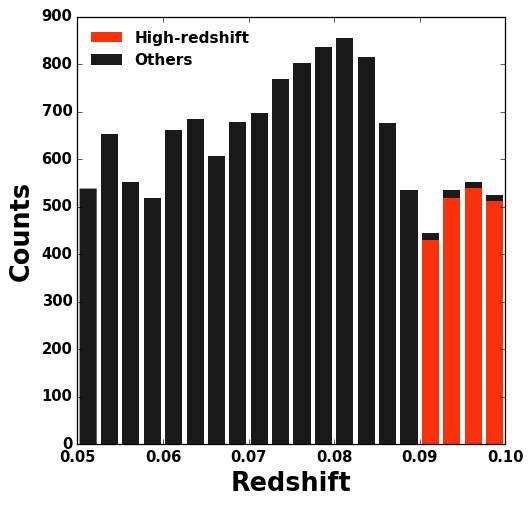

In [6]:
hist([redshift[most_rs], redshift[~most_rs]], 20, histtype="barstacked", color=["#F9320C", "0.1"],
     label=["High-redshift", "Others"])
legend(loc=0, fontsize=12)

xlabel("Redshift")
ylabel("Counts")

In [7]:
vnames, sdss, spec_rd, spec_ur = [], [], [], []

band = [g_res, r_res, i_res]
for i, file in enumerate(snames[most_rs]):
    kflux = loadtxt(odir+"sdss/"+"processed_SDSS_"+file.replace("fit", "txt"), usecols=(1,))
    
    SED = loadtxt(odir+"spec/"+"processed_SPEC_"+file.replace("fit", "txt"), usecols=(0, 1))
    mask = SED[:, 1]>0.0

    rd = CCM(SED[mask, 0], Av[most_rs][i], Rv=3.1)

    sflux_rd = array([integrated_flux(SED[mask, :], b) for b in band])
    SED[mask, 1] /= rd
    sflux_ur = array([integrated_flux(SED[mask, :], b) for b in band])

    vnames.append(file)
    sdss.append(kflux)
    spec_rd.append(sflux_rd)
    spec_ur.append(sflux_ur)

vnames = array(vnames, dtype=str)
sdss = array(sdss)
spec_rd = array(spec_rd)
spec_ur = array(spec_ur)

diff = array([(sdss[:, j+1]/sdss[:, 2]-spec_rd[:, j]/spec_rd[:, 1])*100.0/(spec_rd[:, j]/spec_rd[:, 1]) for j in [0, 2]])

scolor_rd_y = flux2mag(spec_rd[:, 0], weff[1]) - flux2mag(spec_rd[:, 1], weff[2])
scolor_rd_z = flux2mag(spec_rd[:, 0], weff[1]) - flux2mag(spec_rd[:, 2], weff[3])

scolor_ur_y = flux2mag(spec_ur[:, 0], weff[1]) - flux2mag(spec_ur[:, 1], weff[2])
scolor_ur_z = flux2mag(spec_ur[:, 0], weff[1]) - flux2mag(spec_ur[:, 2], weff[3])

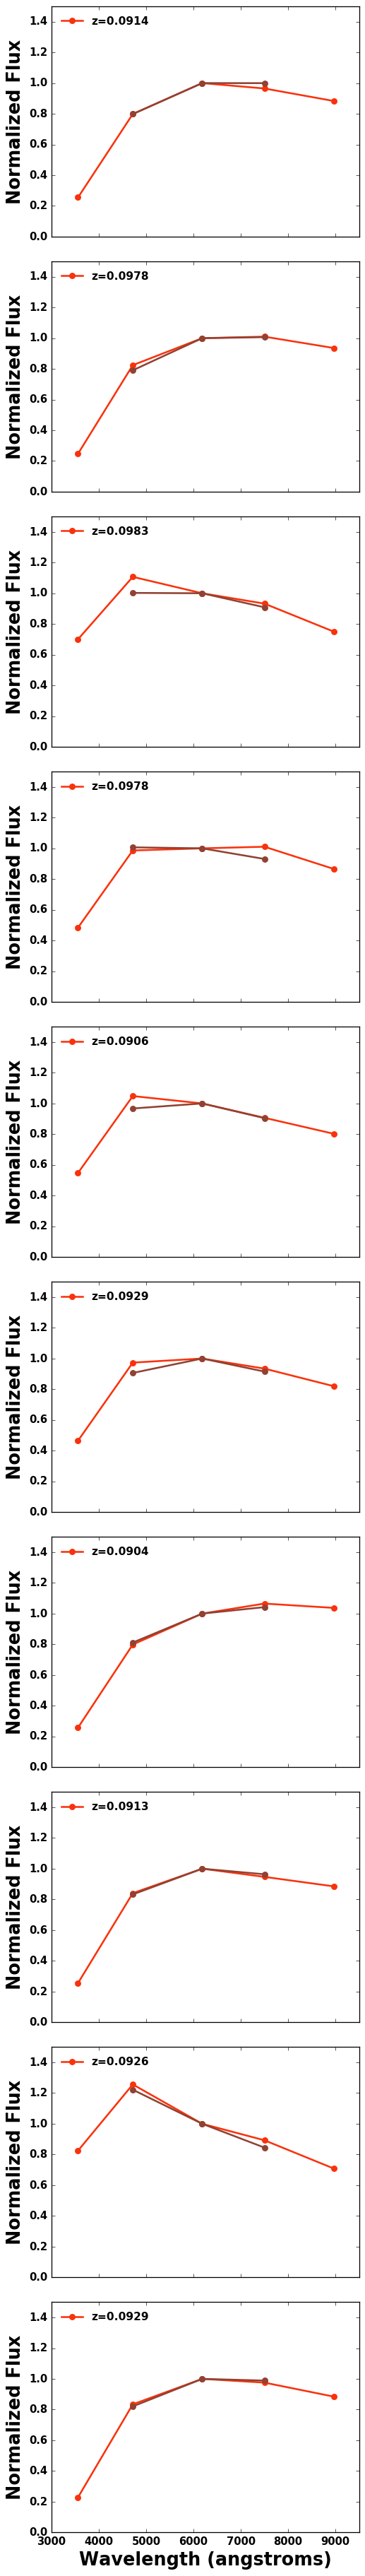

In [8]:
N = 10
fig, axs = subplots(N, 1, sharex=True, sharey=True, figsize=(6, 4*N))

xlim(3000, 9500)
ylim(0.0, 1.5)

for j in xrange(N):
    axs[j].plot(weff, sdss[j]/sdss[j, 2], "o-", color="#F9320C", label="z={0:.4f}".format(redshift[most_rs][j]))
    axs[j].plot(weff[1:-1], spec_rd[j]/spec_rd[j, 1], "o-", color="#904233")

    axs[j].set_ylabel("Normalized Flux")
    axs[j].legend(loc=2, fontsize=12)

xlabel("Wavelength (angstroms)")

fig.tight_layout()

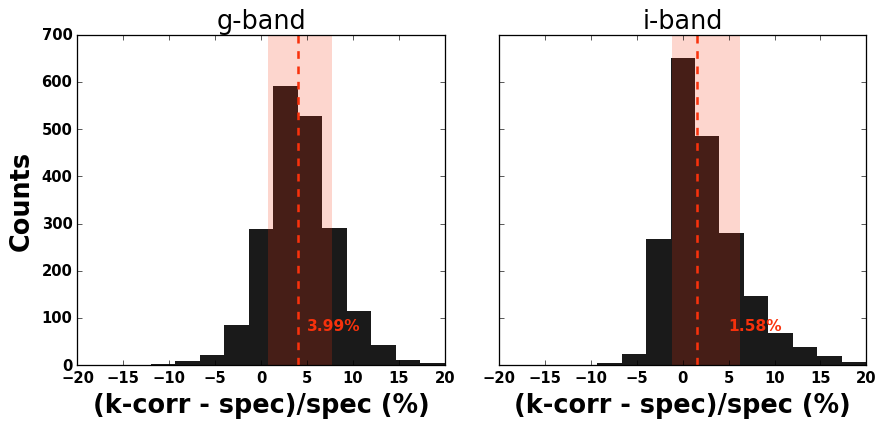

In [9]:
fig, axs = subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

nband = ["g-band", "i-band"]
for j in xrange(axs.size):
    p16, p84 = percentile(diff[j], [16., 84.])
    med = median(diff[j])

    axs[j].hist(diff[j], 15, range=(-20,+20), fc="0.1")
    axs[j].axvspan(p16, p84, fc="#F9320C", alpha=0.2)
    axs[j].axvline(med, ls="--", color="#F9320C")
    
    axs[j].text(5, 100, "{0:.2f}%".format(med), ha="left", va="top", color="#F9320C", size=12)
    
    axs[j].set_title(nband[j])
    axs[j].set_xlabel("(k-corr - spec)/spec (%)")

axs[0].set_ylabel("Counts")

fig.tight_layout()

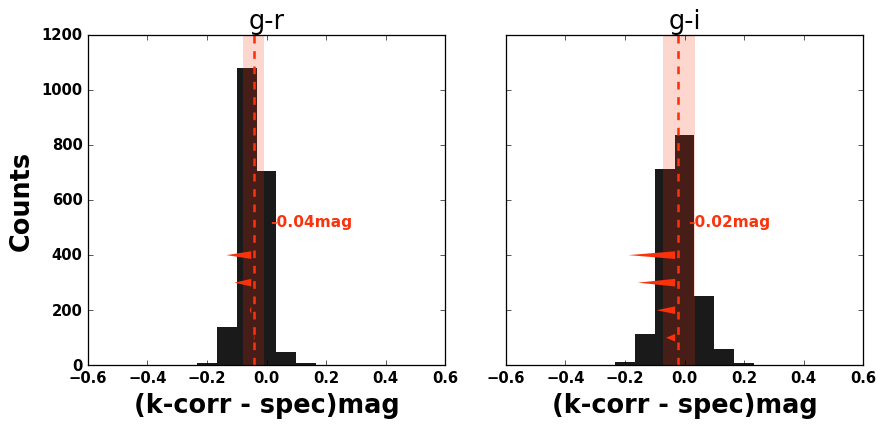

In [10]:
fig, axs = subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

x, kerr_gr = binner(kcolor_x[most_rs], kcolor_y[most_rs]-icolor_y[most_rs], "median", 4, rang=(1, 2))
x, kerr_gi = binner(kcolor_x[most_rs], kcolor_z[most_rs]-icolor_z[most_rs], "median", 4, rang=(1, 2))

ncol = ["g-r", "g-i"]
arr = [kerr_gr, kerr_gi]
yof = (100, 200, 300, 400)
col = [kcolor_y[most_rs] - scolor_rd_y, kcolor_z[most_rs] - scolor_rd_z]
for j in xrange(axs.size):
    p16, p84 = percentile(col[j], [16., 84.])
    med = median(col[j])

    axs[j].hist(col[j], 15, range=(-0.5,+0.5), fc="0.1")
    axs[j].axvspan(p16, p84, fc="#F9320C", alpha=0.2)
    axs[j].axvline(med, ls="--", color="#F9320C")
    
    for i in xrange(len(yof)): axs[j].annotate("", (arr[j][i]-med, yof[i]), (med, yof[i]),
                                               arrowprops=dict(arrowstyle="wedge", fc="#F9320C", ec="none"))
    
    axs[j].text(0.15, 550, "{0:.2f}mag".format(med), ha="center", va="top", color="#F9320C", size=12)
    
    axs[j].set_title(ncol[j])
    axs[j].set_xlabel("(k-corr - spec)mag")

axs[0].set_ylabel("Counts")

fig.tight_layout()

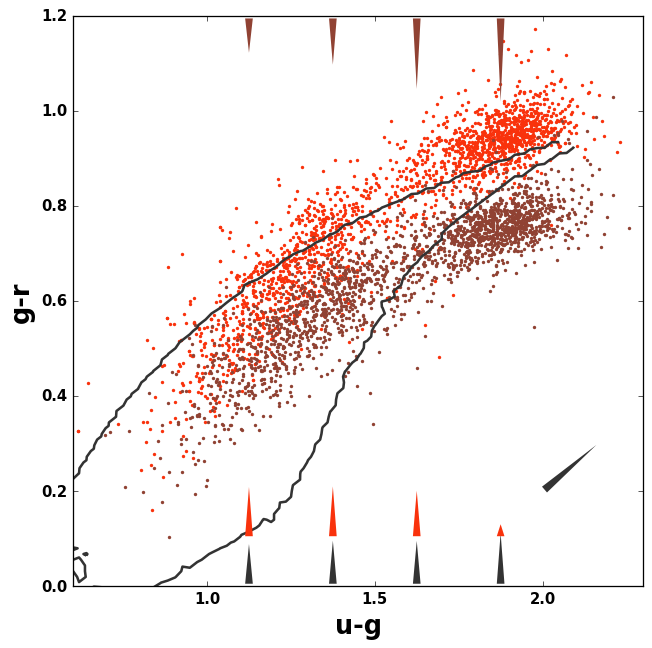

In [11]:
xlm = array((0.6, 2.3))
ylm = array((0.0, 1.2))
fig = figure(figsize=(8,8))
axs = subplot(111, xlim=xlm, ylim=ylm)

lcolor_x = pu_set-pg_set
lcolor_y = pg_set-pr_set

nx, xi, xf, bsx = nbins(lcolor_x)
ny, yi, yf, bsy = nbins(lcolor_y)

H, xe, ye = histogram2d(lcolor_x, lcolor_y, bins=(nx, ny), normed=True)
#H = gaussian_filter(H, sigma=1)

axs.contour(xe[:- 1], ye[:- 1], H.T, levels=[0.05], colors="0.2", linewidths=2)

scatter(icolor_x[most_rs], icolor_y[most_rs], lw=0, c="#F9320C", s=7)
scatter(kcolor_x[most_rs], kcolor_y[most_rs], lw=0, c="#904233", s=7)

x, ug_red = binner(u_set-g_set, (u_set-g_set)-(pu_set-pg_set), "median", 4, rang=(1, 2))
x, gr_red = binner(u_set-g_set, (g_set-r_set)-(pg_set-pr_set), "median", 4, rang=(1, 2))

xo, gro_red = binner(kcolor_x[most_rs], (scolor_rd_y)-(scolor_ur_y), "median", 4, rang=(1, 2))

annotate("", (2+ug_red[2], 0.2+gr_red[2]), (2, 0.2), arrowprops=dict(arrowstyle="wedge", fc="0.2", ec="none"))

for i in xrange(x.size):
    annotate("", (x[i], gr_red[i]), (x[i], 0.0), arrowprops=dict(arrowstyle="wedge", fc="0.2", ec="none"))
    annotate("", (x[i], gro_red[i]+0.1), (x[i], 0.1), arrowprops=dict(arrowstyle="wedge", fc="#F9320C", ec="none"))
    annotate("", (x[i], kerr_gr[i]+1.2), (x[i], 1.2), arrowprops=dict(arrowstyle="wedge", fc="#904233", ec="none"))

xlabel("u-g")
ylabel("g-r")